In [2]:
import stanza
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Setup pipeline
stanza.download('id')
nlp = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma,depparse')


In [11]:
# Load dataset
df = pd.read_csv("../output/normalisasi-dataset-level-soal-2.csv")

# POS tagging
def get_pos_tags(text):
    doc = nlp(text)
    pos_tags = [f"{word.text}/{word.xpos}" for sent in doc.sentences for word in sent.words]
    return " ".join(pos_tags)

df["pos"] = df["soal"].apply(get_pos_tags)

In [12]:
# Hitung kata kerja dan kata hubung
def hitung_kata_kerja_dan_hubung(pos_text):
    words = pos_text.split()
    kata_kerja = sum(1 for word in words if "/V" in word)
    kata_hubung = sum(1 for word in words if any(tag in word for tag in ["/R", "/S", "/C"]))
    return kata_kerja, kata_hubung

df[["kata-kerja", "kata-hubung"]] = df["pos"].apply(lambda x: pd.Series(hitung_kata_kerja_dan_hubung(x)))


In [13]:
# Jumlah kata dan rasio
df["jumlah-kata"] = df["soal"].apply(lambda x: len(str(x).split()))
df["rasio-verb"] = df["kata-kerja"] / df["jumlah-kata"]
df["rasio-conj"] = df["kata-hubung"] / df["jumlah-kata"]

# Kompleksitas linguistik sederhana
df["jumlah-kompleksitas"] = df["kata-kerja"] + df["kata-hubung"]
df["rasio-kompleksitas"] = df["jumlah-kompleksitas"] / df["jumlah-kata"]


In [14]:
# Tambah parsing tree-based fitur
def extract_syntactic_features(text):
    doc = nlp(text)
    depth = 0
    num_subord = 0
    total_dep_distance = 0
    dep_count = 0

    for sent in doc.sentences:
        token_dict = {w.id: w for w in sent.words}
        roots = [w.id for w in sent.words if w.head == 0]

        # DFS untuk hitung depth
        def dfs(node_id, level):
            nonlocal depth
            depth = max(depth, level)
            for child_id in token_dict:
                if token_dict[child_id].head == node_id:
                    dfs(child_id, level + 1)

        for root in roots:
            dfs(root, 1)

        # Subordinasi & jarak dependensi
        for word in sent.words:
            if word.deprel in ['acl', 'advcl', 'ccomp', 'xcomp']:
                num_subord += 1
            if word.head != 0:
                total_dep_distance += abs(word.id - word.head)
                dep_count += 1

    avg_dep_distance = total_dep_distance / dep_count if dep_count > 0 else 0
    return pd.Series([depth, num_subord, avg_dep_distance])

df[["depth", "num_subord", "avg_dep_distance"]] = df["soal"].apply(extract_syntactic_features)


In [15]:
# Korelasi
print("=== Korelasi POS dan Kompleksitas ===")
print("Rasio kata kerja vs level soal     :", df[["rasio-verb", "current-level"]].corr().iloc[0, 1])
print("Rasio kata hubung vs level soal    :", df[["rasio-conj", "current-level"]].corr().iloc[0, 1])
print("Rasio kompleksitas vs level soal   :", df[["rasio-kompleksitas", "current-level"]].corr().iloc[0, 1])

print("\n=== Korelasi Sintaksis Tree ===")
print("Tree Depth vs Level Soal           :", df[["depth", "current-level"]].corr().iloc[0, 1])
print("Jumlah Subordinasi vs Level Soal   :", df[["num_subord", "current-level"]].corr().iloc[0, 1])
print("Rata-rata jarak dependensi vs Level:", df[["avg_dep_distance", "current-level"]].corr().iloc[0, 1])


=== Korelasi POS dan Kompleksitas ===
Rasio kata kerja vs level soal     : -0.04090883220918993
Rasio kata hubung vs level soal    : 0.05756569809901119
Rasio kompleksitas vs level soal   : 0.01746043242379364

=== Korelasi Sintaksis Tree ===
Tree Depth vs Level Soal           : 0.13440802484239153
Jumlah Subordinasi vs Level Soal   : 0.1792644322054268
Rata-rata jarak dependensi vs Level: 0.026214692379693108


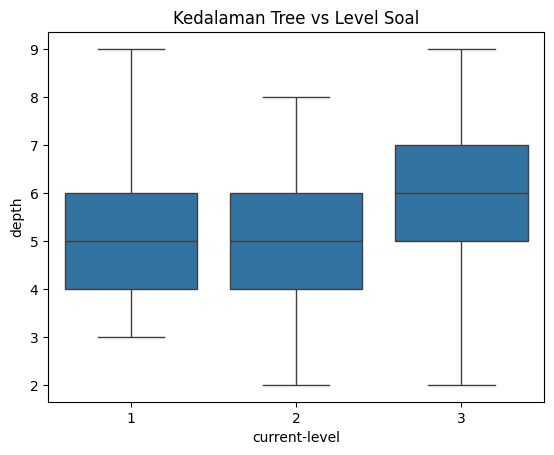

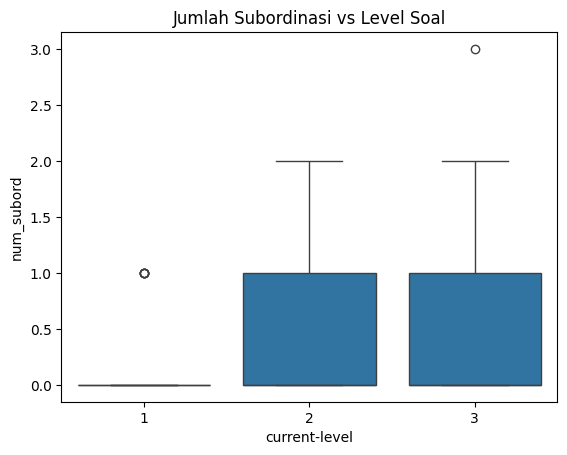

In [16]:

# Visualisasi 
sns.boxplot(data=df, x="current-level", y="depth")
plt.title("Kedalaman Tree vs Level Soal")
plt.show()

sns.boxplot(data=df, x="current-level", y="num_subord")
plt.title("Jumlah Subordinasi vs Level Soal")
plt.show()
